# Libraries and Dictionaries

In [6]:
# %pip install pandas
# %pip install numpy
# %pip install scikit-learn
# %pip install kagglehub
%pip install matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/67/c3/135fdbbbf84e0979712df58e5e22b4f257b3f5e52a3c4aacf1b8abec0d09/matplotlib-3.10.6-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/cc/8f/ec6289987824b29529d0dfda0d74a07cec60e54b9c92f3c9da4c0ac732de/contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/98/12/b6f9f964fe6d4b4dd4406bcbd3328821c3de1f909ffc3ffa558fe72af48c/fonttools-4.59.2-cp312-cp312-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl.metadata
  

In [7]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


## Load Data

In [8]:

# Load a DataFrame with a specific version of a CSV
df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "marcohuiii/english-premier-league-epl-match-data-2000-2025",
    "epl_final.csv",
)

100%|██████████| 715k/715k [00:00<00:00, 12.0MB/s]


## Clean Data

In [9]:
# clean the match-level data
## split the MatchDate into a year, month and date
df['year'] = [int(d.split("-")[0]) for d in df.MatchDate]
df['month'] = [int(d.split("-")[1]) for d in df.MatchDate]
df['day'] = [int(d.split("-")[2]) for d in df.MatchDate]

print(df.columns)


## create a stable unique ID for every team (covers HomeTeam and AwayTeam)
teams = sorted(
    set(df['HomeTeam'].dropna().unique()).union(set(df['AwayTeam'].dropna().unique()))
)

team_to_id = {name: i for i, name in enumerate(teams, start=1)}


# add ID columns to the match dataframe
df['HomeTeamID'] = df['HomeTeam'].map(team_to_id)
if 'AwayTeam' in df.columns:
    df['AwayTeamID'] = df['AwayTeam'].map(team_to_id)

# optional: create a lookup DataFrame and save
# team_lookup = pd.DataFrame(list(team_to_id.items()), columns=['Team', 'TeamID']).sort_values('TeamID')
# team_lookup.to_csv('team_ids.csv', index=False)

# print(f"Created {len(team_lookup)} team ids. Sample:")
# print(team_lookup.head())

Index(['Season', 'MatchDate', 'HomeTeam', 'AwayTeam', 'FullTimeHomeGoals',
       'FullTimeAwayGoals', 'FullTimeResult', 'HalfTimeHomeGoals',
       'HalfTimeAwayGoals', 'HalfTimeResult', 'HomeShots', 'AwayShots',
       'HomeShotsOnTarget', 'AwayShotsOnTarget', 'HomeCorners', 'AwayCorners',
       'HomeFouls', 'AwayFouls', 'HomeYellowCards', 'AwayYellowCards',
       'HomeRedCards', 'AwayRedCards', 'year', 'month', 'day'],
      dtype='object')


In [10]:
# ensure a stable match id
df = df.reset_index(drop=True)
df['MatchID'] = df.index + 1

def team_view(df):
    # home perspective
    home = pd.DataFrame({
        'Season': df['Season'],
        'MatchID': df['MatchID'],
        'MatchDate': df['MatchDate'],
        'year': df['year'],
        'month': df['month'],
        'day': df['day'],
        'Team': df['HomeTeam'],
        'TeamID': df.get('HomeTeamID'),
        'OpponentID': df.get('AwayTeamID'),
        'IsHome': True,
        'GoalsFor': df.get('FullTimeHomeGoals'),
        'GoalsAgainst': df.get('FullTimeAwayGoals'),
        'Shots': df.get('HomeShots'),
        'ShotsOnTarget': df.get('HomeShotsOnTarget'),
        'Corners': df.get('HomeCorners'),
        'Fouls': df.get('HomeFouls'),
        'YellowCards': df.get('HomeYellowCards'),
        'RedCards': df.get('HomeRedCards'),
        'ShotsAgainst': df.get('AwayShots'),
        'ShotsOnTargetAgainst': df.get('AwayShotsOnTarget'),
        'CornersAgainst': df.get('AwayCorners'),
        'FoulsAgainst': df.get('AwayFouls'),
        'YellowCardsAgainst': df.get('AwayYellowCards'),
        'RedCardsAgainst': df.get('AwayRedCards'),
        'HalfTimeResult': df.get('HalfTimeResult')
    })
    # away perspective
    away = pd.DataFrame({
        'Season': df['Season'],
        'MatchID': df['MatchID'],
        'MatchDate': df['MatchDate'],
        'year': df['year'],
        'month': df['month'],
        'day': df['day'],
        'Team': df.get('AwayTeam'),
        'TeamID': df.get('AwayTeamID'),
        'OpponentID': df.get('HomeTeamID'),
        'IsHome': False,
        'GoalsFor': df.get('FullTimeAwayGoals'),
        'GoalsAgainst': df.get('FullTimeHomeGoals'),
        'Shots': df.get('AwayShots'),
        'ShotsOnTarget': df.get('AwayShotsOnTarget'),
        'Corners': df.get('AwayCorners'),
        'Fouls': df.get('AwayFouls'),
        'YellowCards': df.get('AwayYellowCards'),
        'RedCards': df.get('AwayRedCards'),
        'ShotsAgainst': df.get('HomeShots'),
        'ShotsOnTargetAgainst': df.get('HomeShotsOnTarget'),
        'CornersAgainst': df.get('HomeCorners'),
        'FoulsAgainst': df.get('HomeFouls'),
        'YellowCardsAgainst': df.get('HomeYellowCards'),
        'RedCardsAgainst': df.get('HomeRedCards'),
        'HalfTimeResult': df.get('HalfTimeResult')
    })
    return pd.concat([home, away], ignore_index=True)

long_df = team_view(df)

# add outcome from full-time scores (W/L/D from each team's perspective)
def wl_from_scores(row):
    gf = row['GoalsFor']
    ga = row['GoalsAgainst']
    if pd.isna(gf) or pd.isna(ga):
        return None
    if gf > ga:
        return 'W'
    if gf < ga:
        return 'L'
    return 'D'

def points_from_scores(row):
    gf = row['GoalsFor']
    ga = row['GoalsAgainst']
    if pd.isna(gf) or pd.isna(ga):
        return None
    if gf > ga:
        return 3
    if gf < ga:
        return 0
    return 1

long_df['Outcome'] = long_df.apply(wl_from_scores, axis=1)
long_df['Points'] = long_df.apply(points_from_scores, axis=1)

# sort the data by team ID and match ID and create a new variable indicating the teams' game number since beginning of each season
long_df = long_df.sort_values(['Season', 'TeamID', 'MatchID']).reset_index(drop=True)
long_df['Week'] = long_df.groupby(['Season', 'TeamID']).cumcount() + 1
long_df['Week'] = long_df['Week'].astype(int)

# optional: reorder columns
cols = ['Season', 'MatchID','MatchDate', 'Week','year','month','day','Team','TeamID','IsHome',
        'GoalsFor','GoalsAgainst','Outcome', 'Points','Shots','ShotsOnTarget','Corners',
        'Fouls','YellowCards','RedCards',
        'ShotsAgainst', 'ShotsOnTargetAgainst', 'CornersAgainst',
        'FoulsAgainst', 'YellowCardsAgainst','RedCardsAgainst',
        'HalfTimeResult']
long_df = long_df[[c for c in cols if c in long_df.columns]]

#For each team-match observation create the lag of each variable
cols = ['IsHome','GoalsFor','GoalsAgainst','Outcome', 'Shots','ShotsOnTarget','Corners',
        'Fouls','YellowCards','RedCards', 'ShotsAgainst', 'ShotsOnTargetAgainst', 'CornersAgainst',
        'FoulsAgainst','YellowCardsAgainst','RedCardsAgainst',
        'HalfTimeResult']

for c in cols:
    long_df[f'{c}_lag1'] = long_df.groupby(['Season', 'TeamID'])[c].shift(1)

# optional: create a 3-game rolling mean (uses previous games only)
num_cols = [c for c in cols if pd.api.types.is_numeric_dtype(long_df[c])]
for c in num_cols:
    long_df[f'{c}_roll3'] = long_df.groupby(['Season', 'TeamID'])[c].transform(
        lambda s: s.shift(1).rolling(3, min_periods=1).mean()
    )

In [11]:
long_df.columns

Index(['Season', 'MatchID', 'MatchDate', 'Week', 'year', 'month', 'day',
       'Team', 'TeamID', 'IsHome', 'GoalsFor', 'GoalsAgainst', 'Outcome',
       'Points', 'Shots', 'ShotsOnTarget', 'Corners', 'Fouls', 'YellowCards',
       'RedCards', 'ShotsAgainst', 'ShotsOnTargetAgainst', 'CornersAgainst',
       'FoulsAgainst', 'YellowCardsAgainst', 'RedCardsAgainst',
       'HalfTimeResult', 'IsHome_lag1', 'GoalsFor_lag1', 'GoalsAgainst_lag1',
       'Outcome_lag1', 'Shots_lag1', 'ShotsOnTarget_lag1', 'Corners_lag1',
       'Fouls_lag1', 'YellowCards_lag1', 'RedCards_lag1', 'ShotsAgainst_lag1',
       'ShotsOnTargetAgainst_lag1', 'CornersAgainst_lag1', 'FoulsAgainst_lag1',
       'YellowCardsAgainst_lag1', 'RedCardsAgainst_lag1',
       'HalfTimeResult_lag1', 'IsHome_roll3', 'GoalsFor_roll3',
       'GoalsAgainst_roll3', 'Shots_roll3', 'ShotsOnTarget_roll3',
       'Corners_roll3', 'Fouls_roll3', 'YellowCards_roll3', 'RedCards_roll3',
       'ShotsAgainst_roll3', 'ShotsOnTargetAgainst_roll

# Data Exploration

Histogram of winning against the rolling average number of goals for

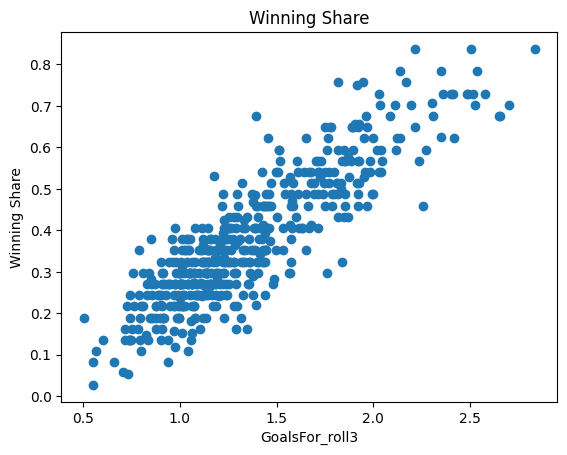

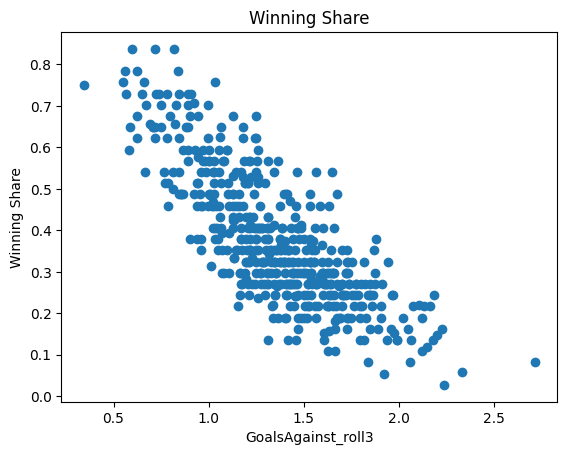

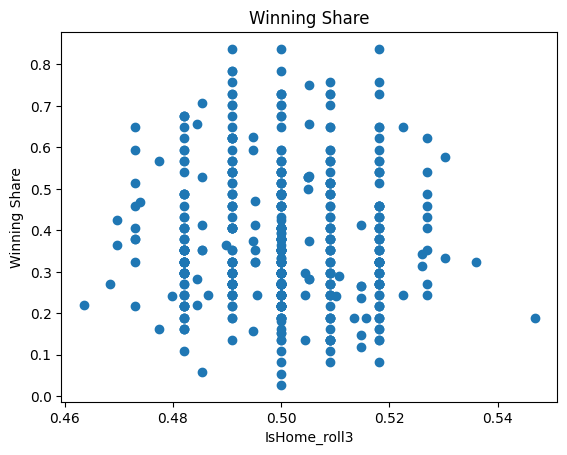

In [14]:
#
data_table = long_df[['Season','TeamID','Outcome', 'GoalsFor_roll3', 'GoalsAgainst_roll3', 'IsHome_roll3']].dropna()
data_table.loc[:, 'Win'] = 0
data_table.loc[data_table['Outcome'] == 'W', 'Win'] = 1
data_table = data_table.groupby(['Season', 'TeamID']).agg(Win = ('Win', 'mean'),
                                                          IsHome_roll3 = ('IsHome_roll3', 'mean'),
                                                          GoalsFor_roll3 = ('GoalsFor_roll3', 'mean'),
                                                          GoalsAgainst_roll3 = ('GoalsAgainst_roll3', 'mean')
                                                          ).reset_index()
cols = ['GoalsFor_roll3', 'GoalsAgainst_roll3', 'IsHome_roll3']
for col in cols:
    plt.scatter(x=data_table[col], y=data_table['Win'])

    plt.xlabel(f'{col}')
    plt.ylabel('Winning Share')
    plt.title('Winning Share')
    plt.show()

Distribution of Outcomes for Home Games

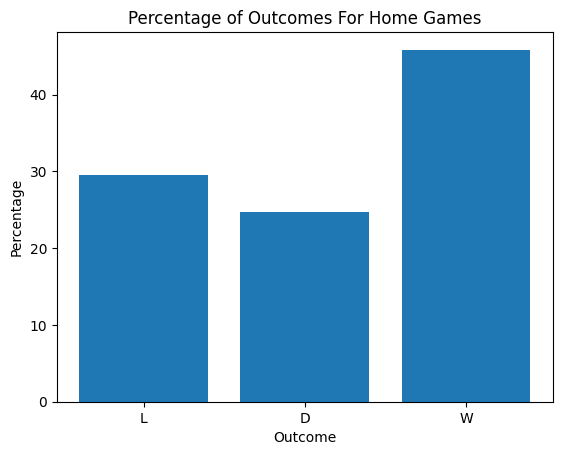

In [15]:
# for season in long_df['Season'].unique():
ishome_stats = long_df.groupby(['IsHome', 'Outcome']).agg(num=('TeamID', 'count')).reset_index()
ishome_stats = ishome_stats[ishome_stats['IsHome'] == True]

desired_order = ['L', 'D', 'W']
ishome_stats['Outcome'] = pd.Categorical(ishome_stats['Outcome'], categories=desired_order, ordered=True)
ishome_stats = ishome_stats.sort_values('Outcome').reset_index(drop=True)

# Calculate the percentage of each outcome
ishome_stats['percent'] = ishome_stats['num'] / ishome_stats['num'].sum() * 100

# Plot the horizontal bar chart
plt.bar(ishome_stats['Outcome'], ishome_stats['percent'])
plt.xlabel('Outcome')
plt.ylabel('Percentage')
plt.title(f'Percentage of Outcomes For Home Games')
plt.show()


Share of Home Wins Across Years

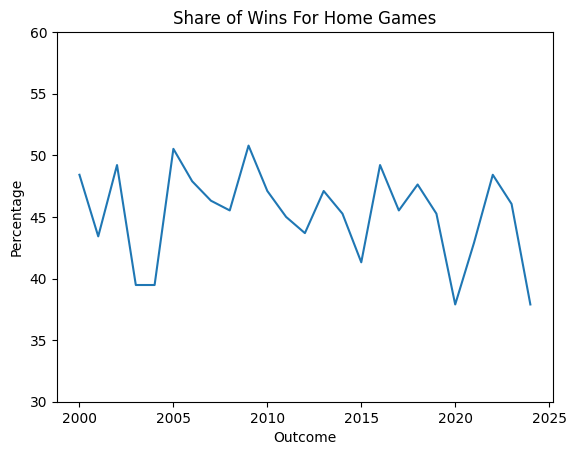

In [16]:
ishome_stats = long_df.groupby(['IsHome','Outcome', 'Season']).agg(num=('TeamID', 'count')).reset_index()
ishome_stats = ishome_stats[(ishome_stats['IsHome'] == True) & (ishome_stats['Outcome'] == 'W')]

# Calculate the percentage of each outcome
# 380 is total number of home games per season? 20 teams, 38 games half of which are home games
ishome_stats['Season'] = [int(p.split('/')[0]) for p in ishome_stats['Season']]
ishome_stats['percent'] = ishome_stats['num'] / 380 * 100
ishome_stats

plt.plot(ishome_stats['Season'], ishome_stats['percent'])

plt.ylim(30, 60)
plt.xlabel('Outcome')
plt.ylabel('Percentage')
plt.title('Share of Wins For Home Games')
plt.show()

# Estimation

## Estimate the K-Nearest Neighbour Model

In [17]:
roll3_cols = [col for col in long_df.columns if col.endswith('_roll3')]
estimation_data = long_df[['Outcome', 'Week', 'IsHome'] + roll3_cols].dropna().copy()

X = estimation_data[['Week', 'IsHome'] + roll3_cols].astype(float)

# encode target to integers (e.g. {'D':0,'L':1,'W':2} depending on classes present)
le = LabelEncoder()
y = le.fit_transform(estimation_data['Outcome'])
label_mapping = {cls: int(i) for i, cls in enumerate(le.classes_)}
print("Label mapping:", label_mapping)

# train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# optional: scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

# Fitting the models.
# knn classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# logistic regression
log_reg = LogisticRegression(penalty=None)
log_reg.fit(X_train, y_train)

# Comparing accuracy on the validation set.
print("KNN: ",accuracy_score(y_test, knn.predict(X_test)))
print("Logistic Regression: ",accuracy_score(y_test, log_reg.predict(X_test)))

Label mapping: {'D': 0, 'L': 1, 'W': 2}
X_train shape: (14608, 17) y_train shape: (14608,)
X_test shape: (3652, 17) y_test shape: (3652,)
KNN:  0.38745892661555315
Logistic Regression:  0.47234392113910184


In [18]:
print(confusion_matrix(y_test, knn.predict(X_test)))

print(confusion_matrix(y_test, log_reg.predict(X_test)))

[[244 370 288]
 [383 683 309]
 [364 523 488]]
[[  0 435 467]
 [  0 858 517]
 [  0 508 867]]


Next to add: Kfold stratification